| **Chapter**                   | 9:  Agent-based models             |
| ----------------------------- |------------------------------------|
| **Computational Note**        | 9.21: ABM of treatment effects     |
| **Package prerequisites**     | [Mesa](http://mesa.readthedocs.io) |

# ABM of treatment effects


In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import json
from scipy import stats
import enum


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0

json      : 2.0.9
pandas    : 1.4.2
scipy     : 1.8.1
mesa      : 0.9.0
numpy     : 1.21.6
networkx  : 2.8.4
matplotlib: 3.5.2



In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    SYMPTOMATIC = 2
    RECOVERED = 3
    DECEASED = 4
    TREATED = 5

In [4]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        self.days_remaining_in_treatment = None
        
    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                                                            if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if (self.state in [State.SYMPTOMATIC, State.EXPOSED] and np.random.rand() < self.model.beta) \
                or (self.state is State.TREATED and np.random.rand < self.model.treatment_beta):
                neighbour.state = State.EXPOSED

    def status_update(self):        
        if self.state == State.SYMPTOMATIC:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED
            elif np.random.rand() < self.model.treatment_fraction:
                self.state = State.TREATED
                self.days_remaining_in_treatment = self.model.treatment_length + 1
        
        if self.state == State.EXPOSED:
            if np.random.rand() < 1/self.model.latency_period:
                self.state = State.SYMPTOMATIC

        if self.state == State.TREATED:
            self.days_remaining_in_treatment -= 1

            if np.random.rand() < 1/self.model.treatment_length:
                if np.random.rand() < self.model.treatment_CFR:
                    self.state = State.DECEASED

            if self.days_remaining_in_treatment < 1:
                self.state = State.RECOVERED
                self.days_remaining_in_treatment = None

        if np.random.rand() < self.model.base_mortality_rate:
            self.state = State.DECEASED


    def step(self):
        self.status_update()

        if self.state in [State.SYMPTOMATIC, State.EXPOSED]:
            self.contact_event()
    

In [5]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=5000, 
                 mean_degree=12,
                 recovery_period=7,
                 latency_period=4,
                 beta=0.01,
                 CFR=0.05,
                 treatment_CFR=0.01,
                 base_mortality_rate=0.000125,
                 treatment_fraction=0.1,
                 treatment_length=7,
                 treatment_beta=0.002,
                 I0=0.05):
                     
        self.N_agents = nodes
        self.recovery_period = recovery_period
        self.latency_period = latency_period
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate
        self.treatment_fraction = treatment_fraction
        self.treatment_length = treatment_length
        self.treatment_beta = treatment_beta
        self.treatment_CFR = treatment_CFR

        self.graph = nx.erdos_renyi_graph(n=self.N_agents, p=mean_degree/self.N_agents)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state = State.EXPOSED

        self.datacollector = DataCollector({"Infectious": lambda m: m.number_infectious()})


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def number_infectious(self):
        return np.sum([1 for i in self.schedule.agents if i.state in (State.SYMPTOMATIC, State.EXPOSED)])

In [6]:
br = batchrunner.FixedBatchRunner(NetworkInfectiousDiseaseModel,
                                  fixed_parameters={"nodes": 5000},
                                  parameters_list=[{"treatment_fraction": 0.1}, {"treatment_fraction": 0.25}, {"treatment_fraction": 0.5}],
                                  iterations=12,
                                  max_steps=60,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [7]:
br.run_all()

36it [01:15,  2.10s/it]


In [8]:
by_treatment_fraction = {}

for i in range(len(br.get_model_vars_dataframe().treatment_fraction)):
    if br.get_model_vars_dataframe().treatment_fraction[i] not in by_treatment_fraction.keys():
        by_treatment_fraction[br.get_model_vars_dataframe().treatment_fraction[i]] = []
    
    by_treatment_fraction[br.get_model_vars_dataframe().treatment_fraction[i]].append(
        br.get_model_vars_dataframe().vals[i].get_model_vars_dataframe()["Infectious"]
    )

In [9]:
means, sds = {}, {}

for i in br.get_model_vars_dataframe().treatment_fraction.unique():
    mu = pd.concat([*(by_treatment_fraction[i])], axis=1).mean(axis=1)
    sigma = pd.concat([*(by_treatment_fraction[i])], axis=1).std(axis=1)

    means[i] = mu
    sds[i] = sigma

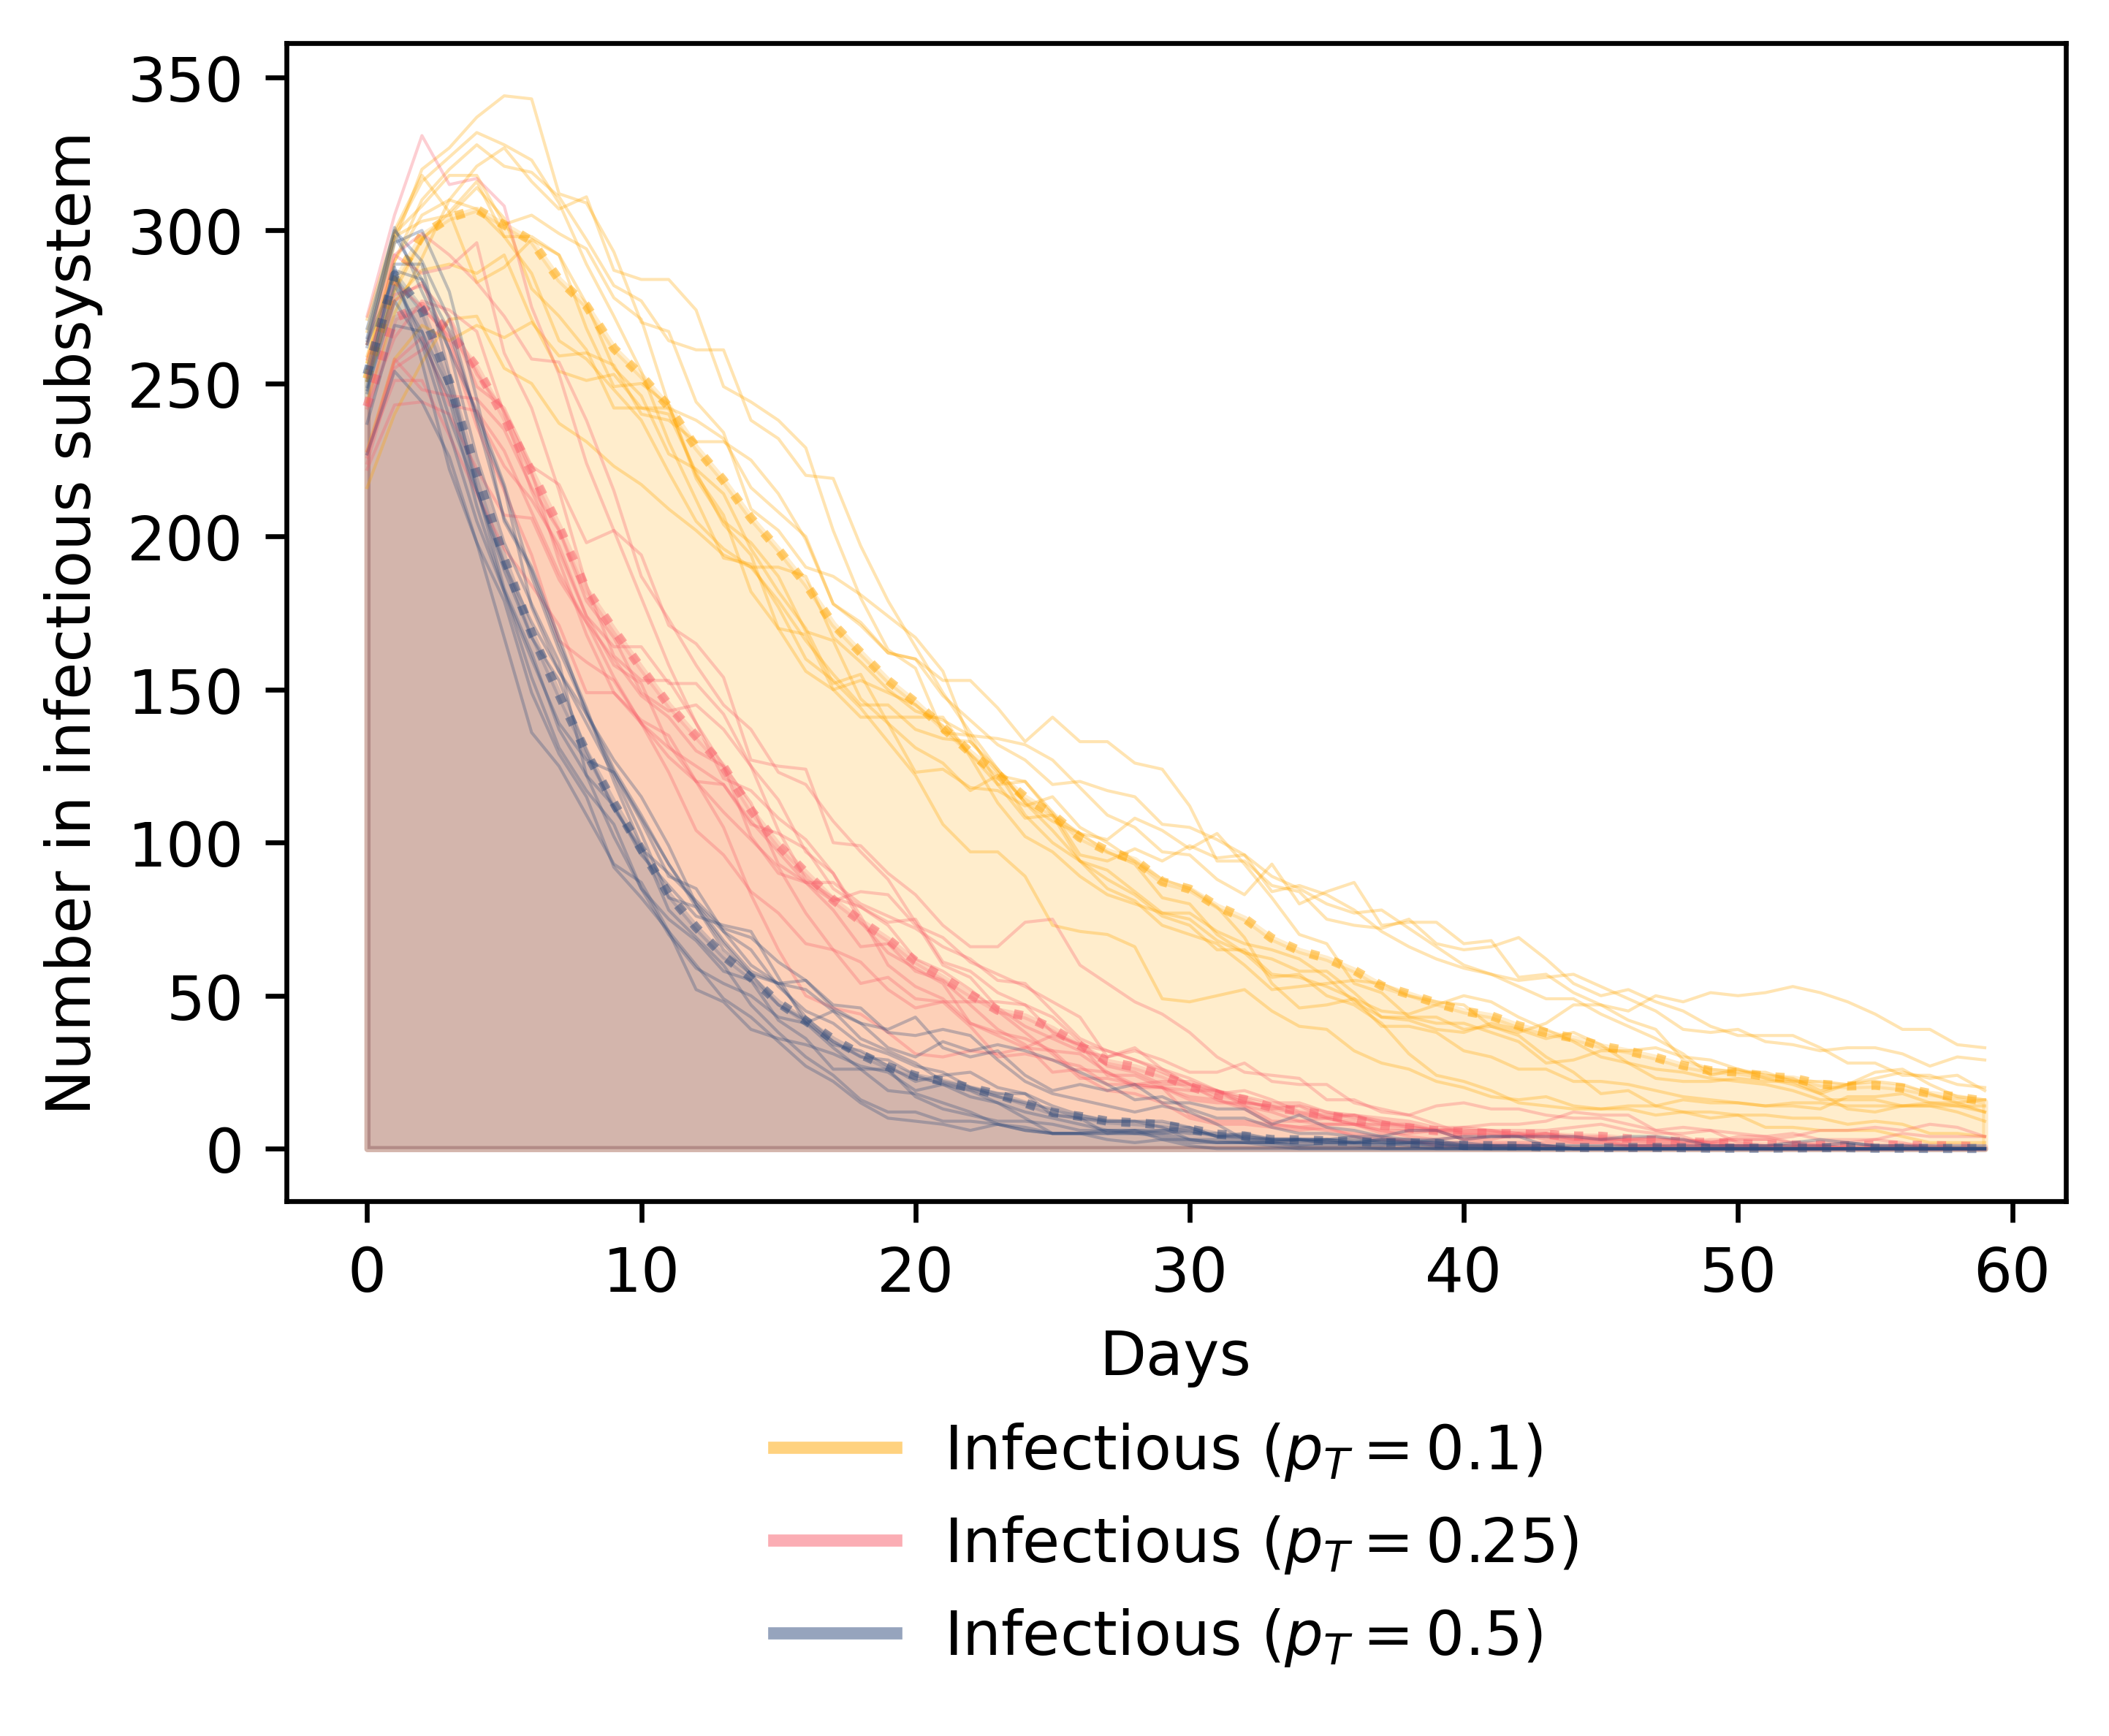

In [13]:
fig = plt.figure(facecolor="w", figsize=(6, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

colour_cycle = ["E", "I", "S"]

logged_qs = []
linestyle_idx = 0

for idx, val in enumerate(by_treatment_fraction.keys()):
    for ts in by_treatment_fraction[val]:
        ax.plot(ts, color=COLORS[colour_cycle[idx]], alpha=0.3, lw=0.5, label="")
        logged_qs.append(val)
    linestyle_idx += 1

    ax.plot(means[val], color=COLORS[colour_cycle[idx]], lw=1.5, alpha=0.5, linestyle=":")
    ax.fill_between(ts.index, means[val], 0, color=COLORS[colour_cycle[idx]], alpha=0.2)

legend_lines = [Line2D([0], [0], color=COLORS["E"], lw=2, alpha=0.5),
                Line2D([0], [0], color=COLORS["I"], lw=2, alpha=0.5),
                Line2D([0], [0], color=COLORS["S"], lw=2, alpha=0.5)]

ax.legend(legend_lines, ["Infectious ($p_T = 0.1$)", "Infectious ($p_T = 0.25$)", "Infectious ($p_T = 0.5$)"], title="", bbox_to_anchor=(0.5, -0.450), loc="lower center", ncol=1, frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Number in infectious subsystem")

fig.tight_layout(pad=5.0)
plt.savefig("SEIRD_with_treatment_ABM.pdf")